In [28]:
!pip install imageio
#!pip install --upgrade tensorflow
!pip install pydot==2.0.0 --upgrade
!pip install seaborn

In [2]:
# Import the required libraries.
import os
import cv2
# import pafy
import math
import random
import numpy as np
import datetime as dt
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import imageio
import imgaug.augmenters as iaa
import imgaug as ia
import tensorflow as tf
import seaborn as sns

In [3]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)

In [5]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 224, 224

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 15

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "dataset"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Accident", "Normal"]

['Accident', 'Normal']
[1, 0]
Normal
['13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_1307_1409.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_1664_1695.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_2164_2217.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_240_305.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_2421_2537.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_2721_2792.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_3061_3170.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_318_545.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_3378_3438.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_5150_5220.mp

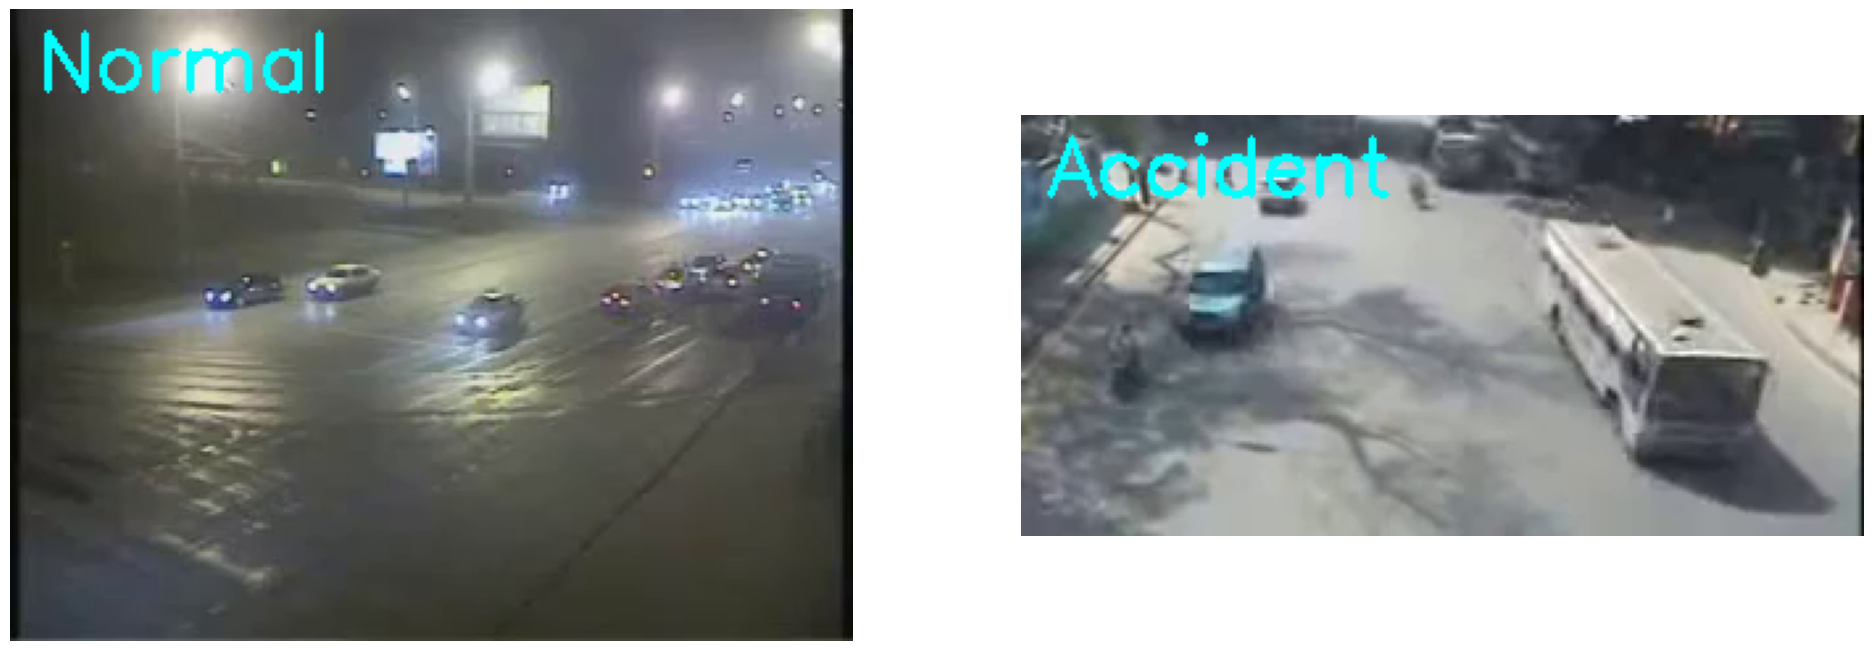

In [5]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (50,50 ))

# Get the names of all classes in dataset
all_classes_names = os.listdir('D:/FYP - 2/MNZ/Accident_Detection/dataset/train')
print(all_classes_names)

random_range = random.sample(range(len(all_classes_names)), 2)
print(random_range)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
    print(selected_class_Name)

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'D:/FYP - 2/MNZ/Accident_Detection/dataset/train/{selected_class_Name}')
    print(video_files_names_list)

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
    print(selected_video_file_name)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'D:/FYP - 2/MNZ/Accident_Detection/dataset/train/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    # rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [6]:
import os
import cv2
import numpy as np
from imgaug import augmenters as iaa

def frames_extraction(video_path, class_name, Dataset_dir):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
        class_name: The name of the class to which the video belongs.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
    
    # Check if the video was opened successfully
    if not video_reader.isOpened():
        print(f"Error: Could not open video {video_path}")
        return frames_list

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if video_frames_count > 0:
        print("Total Frame in video count:", video_frames_count)

        # Calculate the interval after which frames will be added to the list.
        skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)
        print("skip_frames_window:", skip_frames_window)

        # Define the augmentation sequence
        seq = iaa.Sequential([
            iaa.Affine(scale=(0.8, 1.2)),    # Random scaling
            #iaa.Affine(rotate=(-25, 25)),    # Random rotation
            #iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}),  # Random translation
            iaa.Multiply((0.7, 1.3)),        # Random brightness
            #iaa.GaussianBlur(sigma=(0.0, 3.0)), # Random Gaussian blur
            iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Random noise addition
            iaa.ContrastNormalization((0.5, 1.5)),  # Random contrast adjustment
            #iaa.Fliplr(0.5),                  # Random horizontal flip
            iaa.Crop(percent=(0, 0.2))        # Random cropping
        ])

        # Iterate through the Video Frames.
        for frame_counter in range(SEQUENCE_LENGTH):
            # Set the current frame position of the video.
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

            # Reading the frame from the video.
            success, frame = video_reader.read()

            if not success:
                print(f"Warning: Frame {frame_counter} could not be read.")
                continue

            # Perform augmentation only for "Normal" videos
            
            if class_name == "Normal":
                frame = seq(image=frame)

            # Check if the frame is None after augmentation
            if frame is None:
                print(f"Warning: Frame {frame_counter} is None after augmentation.")
                continue

            # Resize the Frame to fixed height and width.
            resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

            # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
            normalized_frame = resized_frame / 255.0

            # Append the normalized frame into the frames list
            frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list


In [7]:
def create_dataset(Dataset_dir):
    i = 0
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    print(CLASSES_LIST)
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(Dataset_dir, class_name))
        files_list = files_list[:3000]
        print(len(files_list))
        np.random.shuffle(files_list)

        # Iterate through all the files present in the files list.
        for file_name in files_list:
            print(i)

            # Get the complete video path.
            video_file_path = os.path.join(Dataset_dir, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path, class_name, Dataset_dir)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the videos having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their respective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
                i = i + 1
                if i == 999:
                    i = 0

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [94]:
train_dir = 'dataset/train'
train_features, train_labels, train_video_file_path = create_dataset(train_dir)

['Accident', 'Normal']
Extracting Data of Class: Accident
400
0
Total Frame in video count: 76
skip_frames_window: 5


d:\Anaconda\envs\tf\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


1
Total Frame in video count: 228
skip_frames_window: 15
2
Total Frame in video count: 85
skip_frames_window: 5
3
Total Frame in video count: 125
skip_frames_window: 8
4
Total Frame in video count: 146
skip_frames_window: 9
5
Total Frame in video count: 203
skip_frames_window: 13
6
Total Frame in video count: 91
skip_frames_window: 6
7
Total Frame in video count: 136
skip_frames_window: 9
8
Total Frame in video count: 214
skip_frames_window: 14
9
Total Frame in video count: 113
skip_frames_window: 7
10
Total Frame in video count: 78
skip_frames_window: 5
11
Total Frame in video count: 114
skip_frames_window: 7
12
Total Frame in video count: 171
skip_frames_window: 11
13
Total Frame in video count: 82
skip_frames_window: 5
14
Total Frame in video count: 65
skip_frames_window: 4
15
Total Frame in video count: 116
skip_frames_window: 7
16
Total Frame in video count: 126
skip_frames_window: 8
17
Total Frame in video count: 175
skip_frames_window: 11
18
Total Frame in video count: 97
skip_f

In [95]:
np.save("features/train/train_features.npy", train_features)
np.save("features/train/train_labels.npy", train_labels)
np.save("features/train/train_video_files_paths.npy", train_video_file_path)

In [8]:
test_dir = 'dataset/test'
test_features, test_labels, test_video_file_path = create_dataset(test_dir)

['Accident', 'Normal']
Extracting Data of Class: Accident
1157
0
Total Frame in video count: 121
skip_frames_window: 8


d:\Anaconda\envs\tf\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


1
Total Frame in video count: 125
skip_frames_window: 8
2
Total Frame in video count: 165
skip_frames_window: 11
3
Total Frame in video count: 83
skip_frames_window: 5
4
Total Frame in video count: 91
skip_frames_window: 6
5
Total Frame in video count: 176
skip_frames_window: 11
6
Total Frame in video count: 81
skip_frames_window: 5
7
Total Frame in video count: 125
skip_frames_window: 8
8
Total Frame in video count: 105
skip_frames_window: 7
9
Total Frame in video count: 118
skip_frames_window: 7
10
Total Frame in video count: 160
skip_frames_window: 10
11
Total Frame in video count: 99
skip_frames_window: 6
12
Total Frame in video count: 219
skip_frames_window: 14
13
Total Frame in video count: 116
skip_frames_window: 7
14
Total Frame in video count: 128
skip_frames_window: 8
15
Total Frame in video count: 148
skip_frames_window: 9
16
Total Frame in video count: 150
skip_frames_window: 10
17
Total Frame in video count: 89
skip_frames_window: 5
18
Total Frame in video count: 99
skip_f

In [9]:
np.save("features/test/test_features.npy", test_features)
np.save("features/test/test_labels.npy", test_labels)
np.save("features/test/test_video_files_paths.npy", test_video_file_path)

Model Defining

In [6]:
from keras.applications.mobilenet_v2 import MobileNetV2
my_model = MobileNetV2(include_top = False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
my_model.trainable = False

my_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                            

In [7]:
from tensorflow.keras.regularizers import l2

In [8]:
def create_model():

    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)
    optimizers = tf.keras.optimizers

    model = Sequential([

    ########################################################################################################################

    #Specifying Input to match features shape
    Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)),

    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    TimeDistributed(my_model),
    Dropout(0.25),
    # Time distributed
    TimeDistributed(Flatten()),

    Bidirectional(lstm_fw, backward_layer = lstm_bw),
    Dropout(0.25),
        # Layer 1
    Dense(256,activation='relu'),
    Dropout(0.25),
    Dense(128,activation='relu'),
    Dropout(0.25),
        # Layer 3
    Dense(64,activation='relu'),
    Dropout(0.25),
        #  Layer 4
    Dense(32,activation='relu'),
    Dropout(0.25),
        # #Layer 1
        # softmax
    Dense(len(CLASSES_LIST), activation = 'sigmoid')
    ])

    adam = optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
    # Compiling the model
    #model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])
    ########################################################################################################################

    model.summary()

    return model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 15, 7, 7, 1280)   2257984   
 tributed)                                                       
                                                                 
 dropout_18 (Dropout)        (None, 15, 7, 7, 1280)    0         
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 62720)        0         
 tributed)                                                       
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               16064768  
 nal)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                      

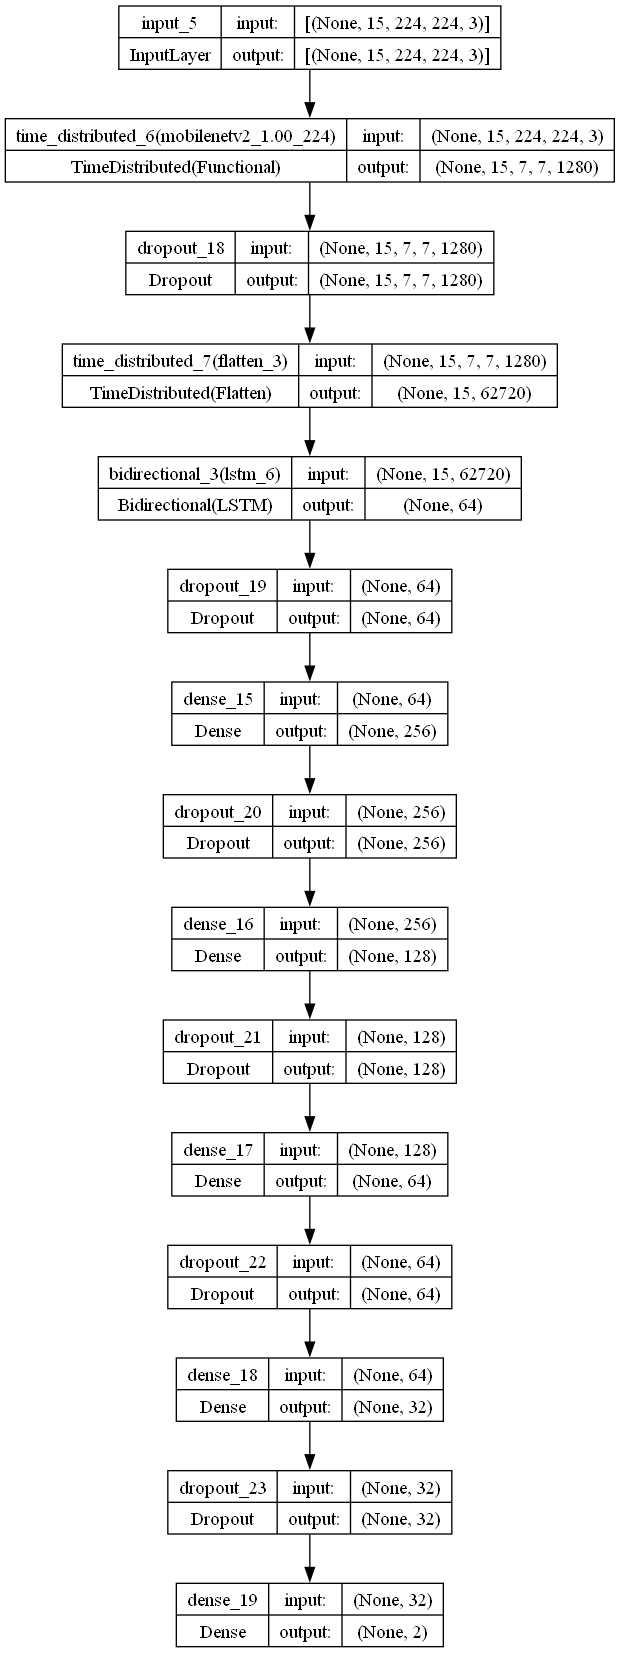

In [34]:
# Constructing the Model
my_LSTM_model = create_model()

# Plot the structure of the contructed LRCN model.
plot_model(my_LSTM_model, to_file = 'my_LSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [10]:
train_features, train_labels, train_video_files_paths = np.load("features/train/train_features.npy") , np.load("features/train/train_labels.npy") ,  np.load("features/train/train_video_files_paths.npy")

MemoryError: Unable to allocate 61.2 GiB for an array with shape (8207539200,) and data type float64

In [10]:
test_features, test_labels, test_video_files_paths = np.load("features/test/test_features.npy", dtype=np.uint16) , np.load("features/test/test_labels.npy", dtype=np.uint16) ,  np.load("features/test/test_video_files_paths.npy", dtype=np.uint16)

In [35]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Create an instance of OneHotEncoder and fit it to the training labels
train_labels = np.load('features/train/train_labels.npy').reshape((-1, 1))
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(train_labels)

def data_generator(feature_file, label_file, batch_size, encoder):
    total_samples = np.load(label_file).shape[0]
    
    while True:
        for i in range(0, total_samples, batch_size):
            X_batch = np.load(feature_file, mmap_mode='r')[i:i + batch_size]
            y_batch = np.load(label_file, mmap_mode='r')[i:i + batch_size].reshape((-1, 1))
            y_batch_encoded = encoder.transform(y_batch)
            yield X_batch.astype(np.float16), y_batch_encoded.astype(np.float16)


In [36]:
batch_size = 32

# Training generator
train_generator = data_generator('features/train/train_features.npy',
                                 'features/train/train_labels.npy',
                                 batch_size,
                                 encoder)

# Validation generator
validation_generator = data_generator('features/test/test_features.npy',
                                      'features/test/test_labels.npy',
                                      batch_size,
                                      encoder)

# Calculate steps per epoch
steps_per_epoch = len(train_labels) // batch_size
validation_steps = len(np.load('features/test/test_labels.npy')) // batch_size


In [37]:
my_LSTM_model_history = my_LSTM_model.fit(
    train_generator,
    epochs=15,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps
)


Epoch 1/15
113/113 [==============================] - 619s 5s/step - loss: 0.8508 - accuracy: 0.8313 - val_loss: 0.8341 - val_accuracy: 0.3426
Epoch 2/15
113/113 [==============================] - 521s 5s/step - loss: 0.8834 - accuracy: 0.4749 - val_loss: 0.6867 - val_accuracy: 0.6574
Epoch 3/15
113/113 [==============================] - 572s 5s/step - loss: 0.8476 - accuracy: 0.6889 - val_loss: 0.6810 - val_accuracy: 0.6574
Epoch 4/15
113/113 [==============================] - 470s 4s/step - loss: 0.8942 - accuracy: 0.7305 - val_loss: 0.6781 - val_accuracy: 0.6574
Epoch 5/15
113/113 [==============================] - 909s 8s/step - loss: 0.8328 - accuracy: 0.7152 - val_loss: 0.6680 - val_accuracy: 0.6574
Epoch 6/15
113/113 [==============================] - 484s 4s/step - loss: 0.8327 - accuracy: 0.7230 - val_loss: 0.6532 - val_accuracy: 0.6574
Epoch 7/15
113/113 [==============================] - 476s 4s/step - loss: 0.6983 - accuracy: 0.7238 - val_loss: 0.6543 - val_accuracy: 0.6574

===============================================Test=============================================

In [1]:
import numpy as np
import os

def save_batches(input_file, batch_size, output_dir):
    # Load the data in chunks
    data = np.load(input_file, mmap_mode='r')
    num_batches = int(np.ceil(data.shape[0] / batch_size))
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    for i in range(num_batches):
        batch_data = data[i*batch_size:(i+1)*batch_size]
        batch_file = os.path.join(output_dir, f'batch_{i}.npy')
        np.save(batch_file, batch_data)
        print(f"Saved {batch_file}")

# Define your batch size and directories
batch_size = 32  # Adjust based on your memory constraints

# Save training features and labels in batches
save_batches('features/train/train_features.npy', batch_size, 'features/train/batched_train_features')
save_batches('features/train/train_labels.npy', batch_size, 'features/train/batched_train_labels')

# Save validation features and labels in batches
save_batches('features/test/test_features.npy', batch_size, 'features/test/batched_test_features')
save_batches('features/test/test_labels.npy', batch_size, 'features/test/batched_test_labels')


Saved features/train/batched_train_features\batch_0.npy
Saved features/train/batched_train_features\batch_1.npy
Saved features/train/batched_train_features\batch_2.npy
Saved features/train/batched_train_features\batch_3.npy
Saved features/train/batched_train_features\batch_4.npy
Saved features/train/batched_train_features\batch_5.npy
Saved features/train/batched_train_features\batch_6.npy
Saved features/train/batched_train_features\batch_7.npy
Saved features/train/batched_train_features\batch_8.npy
Saved features/train/batched_train_features\batch_9.npy
Saved features/train/batched_train_features\batch_10.npy
Saved features/train/batched_train_features\batch_11.npy
Saved features/train/batched_train_features\batch_12.npy
Saved features/train/batched_train_features\batch_13.npy
Saved features/train/batched_train_features\batch_14.npy
Saved features/train/batched_train_features\batch_15.npy
Saved features/train/batched_train_features\batch_16.npy
Saved features/train/batched_train_featur

======================================================================================================

In [15]:
# Fitting the model
from tensorflow.keras.callbacks import ModelCheckpoint

#checkpoint = ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss', mode='min')

my_LSTM_model_history = my_LSTM_model.fit(x = train_features.astype(np.float16), y = train_labels_encoded.astype(np.float16), epochs = 15, batch_size = 4, validation_data=(test_features.astype(np.float16),test_labels_encoded.astype(np.float16)))
# , callbacks = callbacks

MemoryError: Unable to allocate 15.3 GiB for an array with shape (8207539200,) and data type float16

In [108]:
print(test_features.dtype, test_features.shape)
print(test_labels_encoded.dtype, test_labels_encoded.shape)


float64 (287, 15, 224, 224, 3)
float64 (287, 2)


In [29]:
test_features = np.asarray(test_features, dtype=np.float32)
test_labels_encoded = np.asarray(test_labels_encoded, dtype=np.int32)

In [109]:
print(test_features.dtype, test_features.shape)
print(test_labels_encoded.dtype, test_labels_encoded.shape)


float64 (287, 15, 224, 224, 3)
float64 (287, 2)


In [34]:
from tensorflow.keras.backend import clear_session
clear_session()


In [110]:
with tf.device('/CPU:0'):
    model_evaluation_history = my_LSTM_model.evaluate(test_features, test_labels_encoded, batch_size=4)

72/72 [==============================] - 87s 1s/step - loss: 0.3487 - accuracy: 0.8780


In [111]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Get the Epochs Count
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

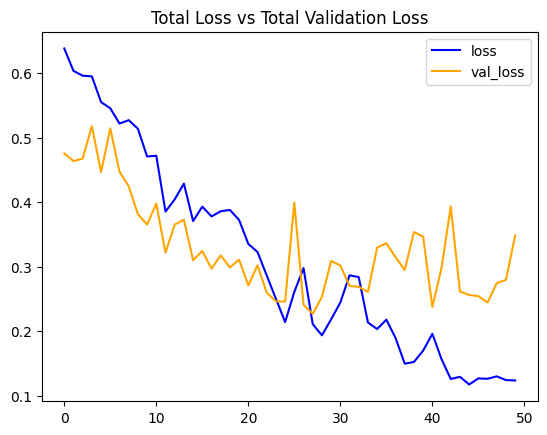

In [112]:
plot_metric(my_LSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

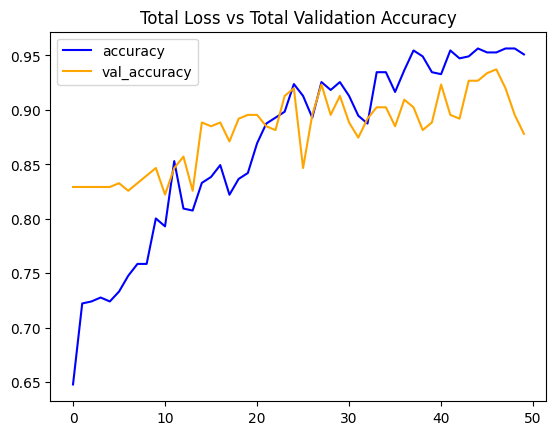

In [113]:
plot_metric(my_LSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Accuracy')

In [114]:
with tf.device('/CPU:0'):
    labels_predict = my_LSTM_model.predict(test_features)

9/9 [==============================] - 74s 8s/step


In [115]:
test_labels_encoded.shape

(287, 2)

In [116]:
print(labels_predict)


[[9.99879301e-01 7.44791250e-05]
 [9.99885559e-01 7.04533304e-05]
 [2.34992817e-01 7.75686860e-01]
 [9.99095500e-01 5.99040650e-04]
 [9.82716441e-01 1.33861043e-02]
 [9.99885559e-01 7.04533304e-05]
 [7.32423961e-01 2.61256635e-01]
 [9.99615371e-01 2.52639409e-04]
 [9.99885559e-01 7.04533304e-05]
 [9.99802411e-01 1.24444588e-04]
 [7.24121332e-01 2.66452909e-01]
 [9.99675512e-01 2.06992656e-04]
 [9.99879241e-01 7.44958888e-05]
 [9.99610126e-01 2.50594720e-04]
 [4.99109834e-01 5.16746998e-01]
 [9.95591462e-01 3.12490505e-03]
 [9.06801581e-01 7.77005628e-02]
 [9.99885559e-01 7.04533304e-05]
 [9.07894313e-01 7.75134116e-02]
 [9.99885559e-01 7.04613922e-05]
 [8.83112013e-01 9.96266529e-02]
 [5.25386095e-01 4.73436892e-01]
 [9.80732679e-01 1.48757473e-02]
 [9.99885559e-01 7.04533304e-05]
 [9.99885559e-01 7.04534614e-05]
 [1.93458855e-01 8.17627609e-01]
 [9.99435365e-01 3.66073567e-04]
 [9.97101486e-01 2.06852122e-03]
 [9.99673784e-01 2.12550061e-04]
 [9.99673784e-01 2.12550061e-04]
 [9.998855

In [117]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(test_labels_encoded , axis=1)

In [118]:
labels_test_normal.shape , labels_predict.shape

((287,), (287,))

In [119]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score( labels_test_normal,labels_predict)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.8780487804878049


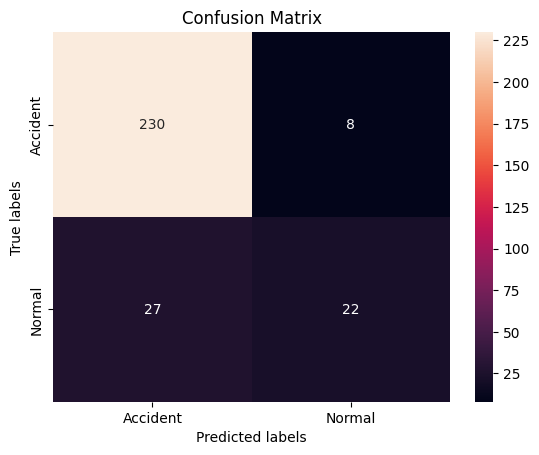

In [120]:

from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Accident',"Normal"]); ax.yaxis.set_ticklabels(['Accident',"Normal"]);

In [121]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       238
           1       0.73      0.45      0.56        49

    accuracy                           0.88       287
   macro avg       0.81      0.71      0.74       287
weighted avg       0.87      0.88      0.87       287



In [122]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
my_LSTM_model.save(model_file_name)

iNFERENCE

In [87]:
import cv2
import numpy as np
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model('convlstm_model___Date_Time_2024_08_06__14_06_07___Loss_0.5817677974700928___Accuracy_0.8585366010665894.h5')

# Open the video file
video_path = 'videos/t2.mp4'
cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.


video_name = f'n1.avi'
out = cv2.VideoWriter(video_name, fourcc, fps, (width, height))

# Parameters
sequence_length = 15  # Adjust this according to your model's expected sequence length
frames = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame (adjust this part according to your model's input requirements)
    preprocessed_frame = cv2.resize(frame, (224, 224))  # Example size
    preprocessed_frame = preprocessed_frame / 255.0  # Normalize if needed
    frames.append(preprocessed_frame)

    # If we have enough frames, make a prediction
    if len(frames) == sequence_length:
        input_sequence = np.array(frames)
        input_sequence = np.expand_dims(input_sequence, axis=0)  # Add batch dimension

        # Make predictions
        predictions = model.predict(input_sequence)

        # Post-process the predictions (adjust according to your model's output)
        label = np.argmax(predictions, axis=1)[0]  # Example for classification

        # Display the label on the frame
        cv2.putText(frame, str(label), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write the frame to the output video
        out.write(frame)

        # Clear the frames list to process the next sequence
        frames = []

    # Display the frame (optional)
    cv2.imshow('Frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    


# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 105ms/step


In [130]:
import cv2
import numpy as np
import tensorflow as tf
import csv

# Load your trained model
model = tf.keras.models.load_model('convlstm_model___Date_Time_2024_08_06__14_44_52___Loss_0.34871038794517517___Accuracy_0.8780487775802612.h5')

# Open the video file
video_path = 'DC.mp4'
cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'XVID')

# Define the output video name
video_name = 'DC.avi'
out = cv2.VideoWriter(video_name, fourcc, fps, (width, height))

# Parameters
sequence_length = 15  # Adjust this according to your model's expected sequence length
frames = []

# List to store predictions
predictions_list = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame (adjust this part according to your model's input requirements)
    preprocessed_frame = cv2.resize(frame, (224, 224))  # Example size
    preprocessed_frame = preprocessed_frame / 255.0  # Normalize if needed
    frames.append(preprocessed_frame)

    # If we have enough frames, make a prediction
    if len(frames) == sequence_length:
        input_sequence = np.array(frames)
        input_sequence = np.expand_dims(input_sequence, axis=0)  # Add batch dimension

        # Make predictions
        predictions = model.predict(input_sequence)

        # Post-process the predictions (adjust according to your model's output)
        label = np.argmax(predictions, axis=1)[0]  # Example for classification

        # Append the label to predictions list
        predictions_list.append(label)

        # Display the label on the frame
        cv2.putText(frame, str(label), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write the frame to the output video
        out.write(frame)

        # Clear the frames list to process the next sequence
        frames = []

    # Display the frame (optional)
    cv2.imshow('Frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

# Save predictions to a file
output_file_path = 'DC_predictions.csv'
with open(output_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Frame_Index', 'Predicted_Label'])
    for index, label in enumerate(predictions_list):
        writer.writerow([index * sequence_length, label])

print(f'Predictions saved to {output_file_path}')


1/1 [==============================] - 0s 76ms/step
Predictions saved to DC_predictions.csv
